In [1]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from paper_visualizations import * 
from PixelEM import * 
# from test_sample import test_sample_obj
import json

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
df = pd.read_csv("pixel_em/MV_PRJ_table.csv")

In [13]:
df = pd.read_csv("pixel_em/MV_PRJ_table.csv")
df = df.rename(columns={"MV_precision":"P [MV]",
                       "MV_recall":"R [MV]",
                       "MV_jaccard":"J [MV]"})
for mode in  ["GT","isoGT","GTLSA","isoGTLSA","basic"]:
    data =  pd.read_csv("pixel_em/{}_ground_truth_full_PRJ_table.csv".format(mode))
    data = data.rename(columns={"EM_precision":"P [{}]".format(mode),
                       "EM_recall":"R [{}]".format(mode),
                       "EM_jaccard":"J [{}]".format(mode),})
    df = df.merge(data)

In [14]:
metric_keys=[u'P [MV]',u'R [MV]', u'J [MV]', u'P [GT]', u'R [GT]', u'J [GT]', u'P [isoGT]',
       u'R [isoGT]', u'J [isoGT]', u'P [GTLSA]', u'R [GTLSA]', u'J [GTLSA]',
       u'P [isoGTLSA]', u'R [isoGTLSA]', u'J [isoGTLSA]', u'P [basic]',
       u'R [basic]', u'J [basic]']

In [15]:
df[df["thresh"]==0].mean()[metric_keys]

P [MV]          0.943431
R [MV]          0.922515
J [MV]          0.872683
P [GT]          0.852214
R [GT]          0.933694
J [GT]          0.795132
P [isoGT]       0.908993
R [isoGT]       0.926589
J [isoGT]       0.843935
P [GTLSA]       0.246115
R [GTLSA]       0.954463
J [GTLSA]       0.242227
P [isoGTLSA]    0.840515
R [isoGTLSA]    0.951290
J [isoGTLSA]    0.803733
P [basic]       0.876459
R [basic]       0.886699
J [basic]       0.793073
dtype: float64

### Performance as it varies with number of workers

No filtering on best threshold

In [16]:
df = df[df["clust"]==-1]

metric_J= [u'J [MV]', u'J [GT]', u'J [isoGT]', u'J [GTLSA]', u'J [isoGTLSA]', u'J [basic]']
df["J [avrg]"]=df[metric_J].mean(axis=1)

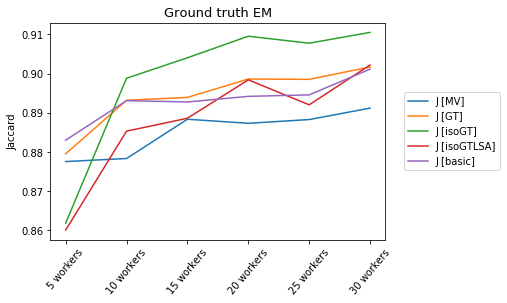

In [34]:
Nworker_performance = df.groupby("num_workers").mean()
MVarr = np.array(Nworker_performance["J [MV]"])
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM",fontsize=13)

In [35]:
print "isoGT="
print list(Nworker_performance['J [isoGT]'])

print "MV="
print list(Nworker_performance['J [MV]'])

isoGT=
[0.86180714318405227, 0.8988109346737535, 0.90404005468171478, 0.90954740011618374, 0.90776463234071514, 0.91052706488955748]
MV=
[0.87752629669525561, 0.87830363026608183, 0.88833647762838908, 0.88730470573821674, 0.88825327097293416, 0.89117292810808058]


In [20]:
#picking the best perform threshold
best_thres_clust = df.loc[df.groupby(['num_workers','sample_num','objid'])["J [avrg]"].idxmax()]

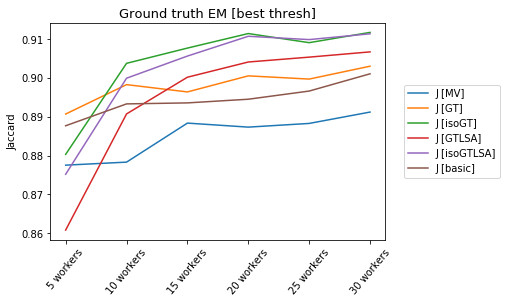

In [22]:
Nworker_performance = best_thres_clust.groupby("num_workers").mean()
MVarr = np.array(Nworker_performance["J [MV]"])
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
#    if '[GTLSA]' not in algo:#exclude GTLSA for now
    plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best thresh]",fontsize=13)

In [30]:
print "isoGT_best_thresh="
print list(Nworker_performance['J [isoGT]'])

isoGT_best_thresh=
[0.88030482691468614, 0.90370402275291195, 0.90762227879598867, 0.91135894959171038, 0.90901508399830366, 0.91165606774023689]


In [11]:
def plot_PRcurve(objid,num_worker,sample_num=0):
    objdf = df[(df["num_workers"]==num_worker)&(df["sample_num"]==sample_num)&(df["objid"]==objid)]
    plt.figure()
    for algo in ['basic','GT','isoGT','GTLSA','isoGTLSA']:
        x= objdf["P [{}]".format(algo)]
        y = objdf["R [{}]".format(algo)]
        if len(x)<=0:
            return
        sortedx, sortedy = zip(*sorted(zip(x, y)))
        plt.plot(sortedx,sortedy,'.-',label=algo)
    plt.xlabel("Precision",fontsize=13)
    plt.ylabel("Recall",fontsize=13)
    plt.legend(loc="bottom left")
    plt.title("{}worker_rand{} [obj {};N={}]".format(num_worker,sample_num,objid,len(objdf)))

# Greedy Algo Results

In [20]:
from glob import glob 
import pandas as pd

globfnames = glob("greedy_old_results/greedy_result_*.csv")
globfnames.remove("greedy_old_results/greedy_result_worker_fraction.csv")
greedy_df = pd.read_csv(globfnames[0],index_col=0)
for fname in globfnames[1:]: 
    greedy_df = greedy_df.append(pd.read_csv(fname,index_col=0))

assert len(greedy_df)==31*44*5

greedy_df.to_csv("greedy_old_results/all_greedy_result.csv")

In [23]:
greedy_df = pd.read_csv("greedy_old_results/all_greedy_result.csv",index_col=0)

ground_truth_greedy_df = pd.read_csv("ground_truth_greedy_result.csv")
greedy_df = greedy_df.append(ground_truth_greedy_df)
worker_frac_greedy_df = pd.read_csv("greedy_old_results/greedy_result_worker_fraction.csv")
greedy_df = greedy_df.append(worker_frac_greedy_df)

greedy_df["num_workers"] = greedy_df["sample"].apply(lambda x: int(x.split("workers")[0]))

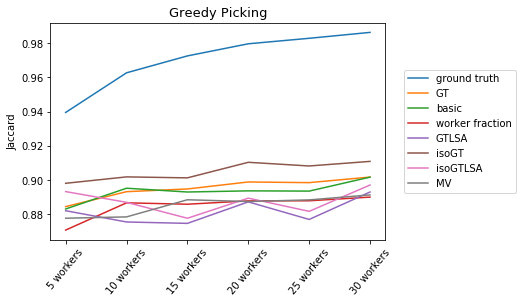

In [24]:
Nworker_performance = greedy_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [ ]:
30workers_rand0	7	basic	0.888850	0.571079	0.533015

In [48]:
greedy_df[(greedy_df["sample"]=="30workers_rand0")&(greedy_df["objid"]==7)]

,sample,objid,algo,p,r,j,num_workers
30,30workers_rand0,7,basic,0.888850,0.571079,0.533015,30
31,30workers_rand0,7,GT,0.883962,0.949055,0.843917,30
32,30workers_rand0,7,isoGT,0.936327,0.932369,0.876778,30
33,30workers_rand0,7,GTLSA,0.928919,0.848943,0.797159,30
34,30workers_rand0,7,isoGTLSA,0.943166,0.930367,0.880977,30
1018,30workers_rand0,7,ground truth,0.986317,0.978198,0.965101,30
1018,30workers_rand0,7,worker fraction,0.882112,0.575973,0.534807,30


This is interesting, the object performed badly with basic and worker fraction but advacned methods resolved this

In [54]:
greedy_df[(greedy_df["j"]<0.7)&(greedy_df["num_workers"]==30)]

,sample,objid,algo,p,r,j,num_workers
30,30workers_rand0,7,basic,0.888850,0.571079,0.533015,30
138,30workers_rand0,28,GTLSA,0.256703,0.955701,0.253684,30
139,30workers_rand0,28,isoGTLSA,0.257111,0.963182,0.254608,30
1018,30workers_rand0,7,worker fraction,0.882112,0.575973,0.534807,30
1026,30workers_rand0,15,worker fraction,0.681879,1.000000,0.681879,30


# Picking out poorly performing objects from Greedy EM 

Things that fail with GTLSA 

In [22]:
df["J [GTLSA-MV]"]=df["J [GTLSA]"]-df["J [MV]"]
df["J [GTLSA-MV]"] = df["J [GTLSA-MV]"].abs()

In [37]:
df[(df["num_workers"]>20)&(df["J [GTLSA-MV]"]>0.5)].head()

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6170,30,0,3,0.962144,0.914391,0.882636,-4,0.934359,0.956933,0.896654,...,0.011386,0.915441,0.011374,0.961830,0.933036,0.899721,0.960418,0.917542,0.884109,0.871263
6171,30,0,3,0.962144,0.914391,0.882636,-2,0.934582,0.956670,0.896628,...,0.011353,0.912815,0.011341,0.962701,0.928571,0.896324,0.961168,0.916492,0.883768,0.871295
6172,30,0,3,0.962144,0.914391,0.882636,0,0.934515,0.955620,0.895644,...,0.011312,0.909401,0.011299,0.967813,0.923845,0.896306,0.961942,0.915966,0.883933,0.871337
6175,30,0,4,0.944882,0.945455,0.896037,-4,0.910654,0.979091,0.893282,...,0.010244,0.939394,0.010237,0.935834,0.967879,0.907644,0.944813,0.949394,0.899512,0.885800
6176,30,0,4,0.944882,0.945455,0.896037,-2,0.912048,0.977273,0.893104,...,0.010211,0.936364,0.010204,0.938421,0.965152,0.907666,0.944780,0.948788,0.898938,0.885832


It seems like for this case the GTLSA is failing because of some thresholds 

In [40]:
df[(df["num_workers"]==30)&(df["sample_num"]==0)&(df["objid"]==3)]#["J [GTLSA]"]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6170,30,0,3,0.962144,0.914391,0.882636,-4,0.934359,0.956933,0.896654,...,0.011386,0.915441,0.011374,0.961830,0.933036,0.899721,0.960418,0.917542,0.884109,0.871263
6171,30,0,3,0.962144,0.914391,0.882636,-2,0.934582,0.956670,0.896628,...,0.011353,0.912815,0.011341,0.962701,0.928571,0.896324,0.961168,0.916492,0.883768,0.871295
6172,30,0,3,0.962144,0.914391,0.882636,0,0.934515,0.955620,0.895644,...,0.011312,0.909401,0.011299,0.967813,0.923845,0.896306,0.961942,0.915966,0.883933,0.871337
6173,30,0,3,0.962144,0.914391,0.882636,2,0.934447,0.954569,0.894659,...,0.977740,0.899685,0.881626,0.971706,0.919905,0.895908,0.962207,0.915966,0.884157,0.001010
6174,30,0,3,0.962144,0.914391,0.882636,4,0.939425,0.952994,0.897823,...,0.978516,0.897059,0.879732,0.972920,0.915179,0.892446,0.962176,0.915179,0.883397,0.002904


In [41]:
df[(df["num_workers"]==30)&(df["sample_num"]==0)&(df["objid"]==4)]#["J [GTLSA]"]

,num_workers,sample_num,objid,P [MV],R [MV],J [MV],thresh,P [GT],R [GT],J [GT],...,P [GTLSA],R [GTLSA],J [GTLSA],P [isoGTLSA],R [isoGTLSA],J [isoGTLSA],P [basic],R [basic],J [basic],J [GTLSA-MV]
6175,30,0,4,0.944882,0.945455,0.896037,-4,0.910654,0.979091,0.893282,...,0.010244,0.939394,0.010237,0.935834,0.967879,0.907644,0.944813,0.949394,0.899512,0.885800
6176,30,0,4,0.944882,0.945455,0.896037,-2,0.912048,0.977273,0.893104,...,0.010211,0.936364,0.010204,0.938421,0.965152,0.907666,0.944780,0.948788,0.898938,0.885832
6177,30,0,4,0.944882,0.945455,0.896037,0,0.914845,0.976667,0.895278,...,0.010195,0.934848,0.010188,0.943520,0.961818,0.909456,0.945048,0.948485,0.898909,0.885849
6178,30,0,4,0.944882,0.945455,0.896037,2,0.916927,0.976667,0.897272,...,0.963636,0.931515,0.899883,0.946707,0.958182,0.909143,0.945015,0.947879,0.898334,0.003846
6179,30,0,4,0.944882,0.945455,0.896037,4,0.916856,0.975758,0.896437,...,0.966214,0.927273,0.898151,0.951705,0.955455,0.911272,0.946412,0.947273,0.899051,0.002114


same with this one

# What is the performance if we only pick easy objects? 

In [76]:
# Task difficulty
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
type_one_task_ambiguity = [15,20,22,27,31,40,41,42,47] #wrong object annotation
type_two_task_ambiguity = [1,4,7,8,9,10,18,20,21,25,28,29,30,31,32,33,34,35] #missing region


small_area = [1,15,22]
high_numPts=[5,7,9,10,11,12,28,29,30,37]
all_hard_tasks = list(set(np.concatenate((type_one_task_ambiguity,type_two_task_ambiguity))))
easy_tasks = [objid  for objid in object_lst if objid not in all_hard_tasks]

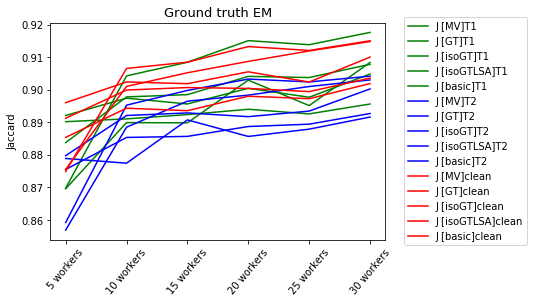

In [81]:
Nworker_performance = df[~df["objid"].isin(type_one_task_ambiguity)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"T1",color="green")
        

Nworker_performance = df[~df["objid"].isin(type_two_task_ambiguity)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"T2",color="blue")
        
Nworker_performance = df[df["objid"].isin(easy_tasks)].groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo+"clean",color="red")

plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM",fontsize=13)

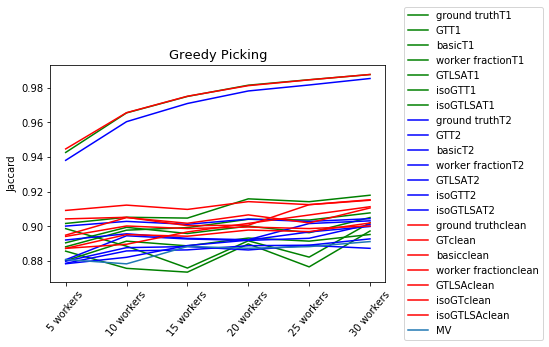

In [80]:
Nworker_performance = greedy_df[~greedy_df["objid"].isin(type_one_task_ambiguity)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"T1",color="green")
#
Nworker_performance = greedy_df[~greedy_df["objid"].isin(type_two_task_ambiguity)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"T2",color="blue")
#
Nworker_performance = greedy_df[greedy_df["objid"].isin(easy_tasks)].groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo+"clean",color="red")
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [73]:
len(easy_tasks)

41

In [74]:
len(object_lst)

44